<a href="https://colab.research.google.com/github/pipeton8/6.439-stats-comp-applications/blob/main/Assignments/4%20-%20Networks/6.439%20-%20Problem%20Set%204.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Set 4 - Statistics, Computation and Applications

(c) Felipe del Canto, November 2021
***
***

# Part 0 (Execute first!)

In [1]:
from IPython.display import clear_output

# Download files
!wget https://github.com/pipeton8/6.439-stats-comp-applications/raw/main/Assignments/databases/PS4_data.zip

# Unzip
!unzip -o PS4_data.zip
!rm *.z* -r __MACOSX

# Clear output
clear_output()

# Import packages
import warnings

import scipy
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.4f}'.format

import seaborn           as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm, trange

# Problem 4.2: Co-offending Network

## Preamble

In [3]:
# Load data
co_off = pd.read_csv("Cooffending.csv")

# Set date
co_off['date'] = pd.to_datetime(co_off['date'])

# Set crime codes, counties and locations as categorical
categorical_vars = (['offender_id', 'sex', 'event_id'] 
                    + ['crime_code'] 
                    + ['county', 'location'])
co_off[categorical_vars] = co_off[categorical_vars].astype('category')

## (a), (b), (c), (d): Data exploration

This dataset contains 1,465,786 entries. Each observation is taken at the `offender_id`-`event_id`-`crime_code` level. This is, individual offenders arrested at a given crime event and charged with a certain crime. 

Note that at any given crime event, the offender can be charged several different crimes.





In [6]:
co_off.shape[0]

1465786

Within, the number of unique offenders is 538,851, and the number of different crime events are 1,163,423, which occurred between 197 and 2004 according to the following table:

| Year | Number of arrests |
|:--:|:--:|
| 1997 |	22404  |
| 1998 |	142582 |
| 1999 |	163346 |
| 2000 |	220197 |
| 2001 |	234495 |
| 2002 |	246397 |
| 2003 |	251298 |
| 2004 |	185067 |

In [7]:
co_off[['offender_id', 'event_id']].describe(include='all')

,offender_id,event_id
count,1465786,1465786
unique,538851,1163423
top,325612,479688
freq,670,408


In [8]:
co_off[['offender_id', 'year']].groupby(['year']).count()

,offender_id
year,
1997,22404
1998,142582
1999,163346
2000,220197
2001,234495
2002,246397
2003,251298
2004,185067


We can observe a total of 301 different crime codes (different offenses). And within each code there is high variability, with one of the crimes accounting for more than 140,000 of the observations (almost 10% of the sample).

In [10]:
co_off['crime_code'].describe()

count     1465786
unique        301
top            22
freq       140901
Name: crime_code, dtype: int64

In [16]:
group_by_code = co_off.groupby('crime_code').count()

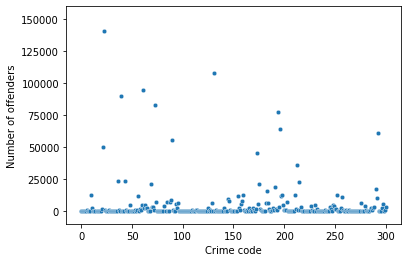

In [23]:
# Axis offsets
offset = (15,10000)

# Initialize figure
fig, ax = plt.subplots()

# Draw histplot using offender_id count as y-axis
sns.scatterplot(data=group_by_code, x='crime_code', y='offender_id', s=20, ax = ax)

# Set xticks
xticks = [50 * k for k in range(7)]
xlabels = xticks

plt.xticks(ticks=xticks, labels=xlabels, rotation=0, horizontalalignment = 'center')
plt.xlim(xticks[0] - offset[0], xticks[-1] + offset[0])

# Set yticks
yticks = [25000 * k for k in range(7)]
ylabels = yticks

plt.yticks(yticks, ylabels)
plt.ylim(yticks[0] - offset[1], yticks[-1] + offset[1])

# Set axis titles
plt.xlabel("Crime code")
plt.ylabel("Number of offenders")

fig.show()

To gain more insight, the sample is restricted to crimes with less or equal than 5,000 offenders. For reference, the average number of offenders per crime is, approximately, 4,869. With this, of the 294 different codes, 254 (86.3%) remain.

The plot changes slightly. Most of the codes have little offenders and, among the rest, there is high variability.

In [29]:
group_by_code_small = group_by_code[group_by_code['offender_id'] <= 5000]
group_by_code_small.shape

(254, 9)

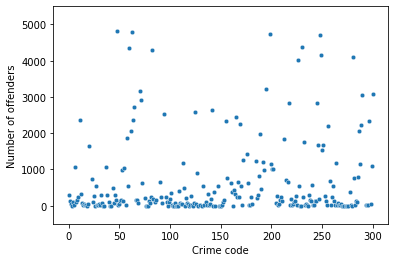

In [34]:
# Axis offsets
offset = (15,500)

# Initialize figure
fig, ax = plt.subplots()

# Draw histplot using offender_id count as y-axis
sns.scatterplot(data=group_by_code_small, x='crime_code', y='offender_id', s=20, ax = ax)

# Set xticks
xticks = [50 * k for k in range(7)]
xlabels = xticks

plt.xticks(ticks=xticks, labels=xlabels, rotation=0, horizontalalignment = 'center')
plt.xlim(xticks[0] - offset[0], xticks[-1] + offset[0])

# Set yticks
yticks = [1000 * k for k in range(6)]
ylabels = yticks

plt.yticks(yticks, ylabels)
plt.ylim(yticks[0] - offset[1], yticks[-1] + offset[1])

# Set axis titles
plt.xlabel("Crime code")
plt.ylabel("Number of offenders")

fig.show()

The 5 crimes with the most offenders are:

| Crime code | Number of offenders |
|:--:|:--:|
| 22   |  140901 |
| 131  |  108031 |
| 61   |   94655 |
| 39   |   90179 |
| 73   |   83110 |

These occur mostly in 

In [46]:
most_offenders = group_by_code.sort_values(by='offender_id', ascending=False).iloc[:5,:]
most_offenders['offender_id']

crime_code
22     140901
131    108031
61      94655
39      90179
73      83110
Name: offender_id, dtype: int64

In [50]:
most_offenders = most_offenders.index.to_numpy()
most_offenders

array([ 22, 131,  61,  39,  73])

In [53]:
location_of_most_offenders = co_off[co_off['crime_code'].isin(most_offenders)]

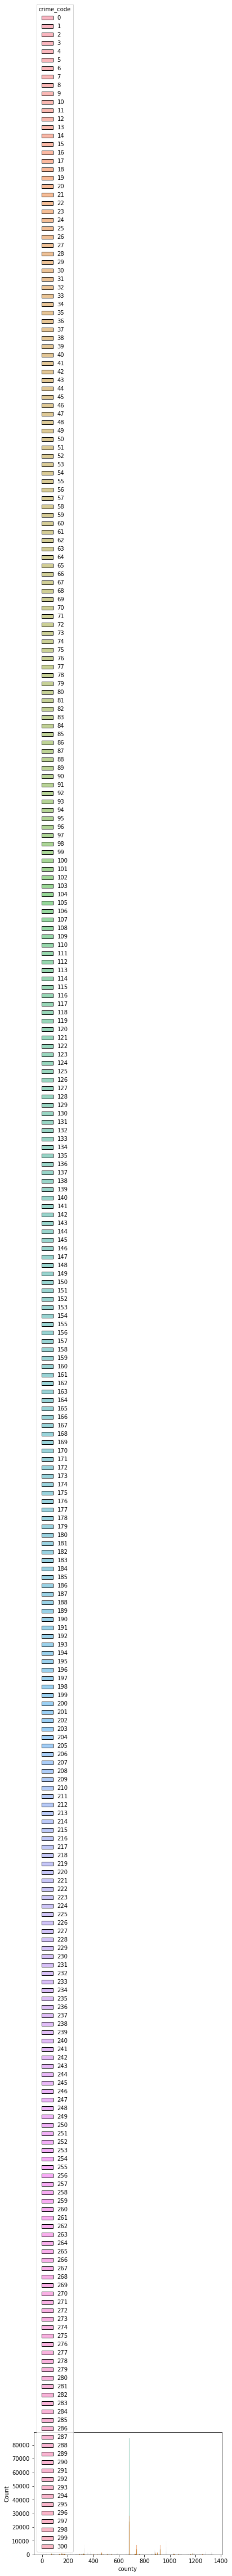

In [54]:
# Axis offsets
offset = (15,500)

# Initialize figure
fig, ax = plt.subplots()

# Draw histplot using offender_id count as y-axis
sns.histplot(data=location_of_most_offenders, x='county', hue='crime_code', ax = ax)

# Set xticks
# xticks = [50 * k for k in range(7)]
# xlabels = xticks

# plt.xticks(ticks=xticks, labels=xlabels, rotation=0, horizontalalignment = 'center')
# plt.xlim(xticks[0] - offset[0], xticks[-1] + offset[0])

# # Set yticks
# yticks = [1000 * k for k in range(6)]
# ylabels = yticks

# plt.yticks(yticks, ylabels)
# plt.ylim(yticks[0] - offset[1], yticks[-1] + offset[1])

# # Set axis titles
# plt.xlabel("Crime code")
# plt.ylabel("Number of offenders")

fig.show()

## (b)

## (c)

## (d)

## (e)

## (f)

## (g)

## (h)

## (i)

## (j)

## (k)

## (l)

## (m)